In [163]:
import numpy as np
import cv2
import PIL as PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda

**Make predictions using ready made model (without any training)**

In [222]:
IMAGE_SHAPE = (224, 224)

mobilenet_model = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",
    input_shape=IMAGE_SHAPE+(3,),  
    trainable=False  
)

classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: mobilenet_model.call(x))
])

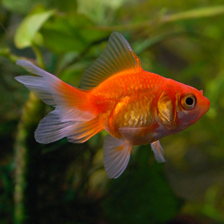

In [223]:
gold_fish = Image.open("Images/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [224]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [225]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [226]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


(1, 1001)

In [227]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [228]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [229]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [230]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


In [232]:
data_dir

'./datasets/flower_photos'

In [233]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [234]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/16209331331_343c899d38.jpg'),
 PosixPath('datasets/flower_photos/roses/5777669976_a205f61e5b.jpg'),
 PosixPath('datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15011625580_7974c44bce.jpg'),
 PosixPath('datasets/flower_photos/roses/17953368844_be3d18cf30_m.jpg')]

In [235]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [236]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/16209331331_343c899d38.jpg'),
 PosixPath('datasets/flower_photos/roses/5777669976_a205f61e5b.jpg'),
 PosixPath('datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15011625580_7974c44bce.jpg'),
 PosixPath('datasets/flower_photos/roses/17953368844_be3d18cf30_m.jpg')]

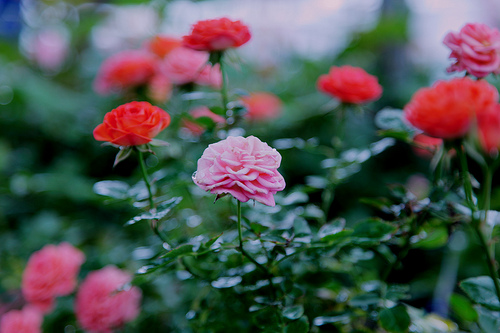

In [237]:
PIL.Image.open(str(roses[1]))

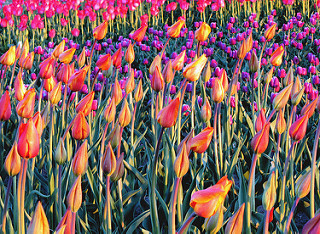

In [238]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [239]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [240]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [241]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/16209331331_343c899d38.jpg'),
 PosixPath('datasets/flower_photos/roses/5777669976_a205f61e5b.jpg'),
 PosixPath('datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15011625580_7974c44bce.jpg'),
 PosixPath('datasets/flower_photos/roses/17953368844_be3d18cf30_m.jpg')]

In [242]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/16209331331_343c899d38.jpg'

In [243]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [244]:
img.shape

(243, 500, 3)

In [245]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [246]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [247]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [249]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [250]:
X[0].shape

(224, 224, 3)

In [251]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [252]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

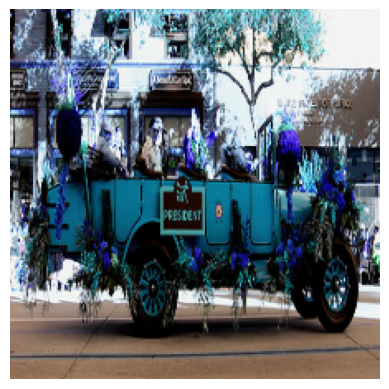

In [253]:
plt.axis('off')
plt.imshow(X[0])

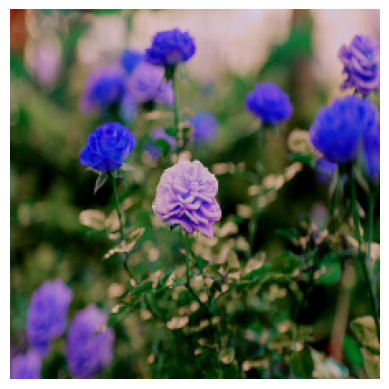

In [254]:
plt.axis('off')
plt.imshow(X[1])

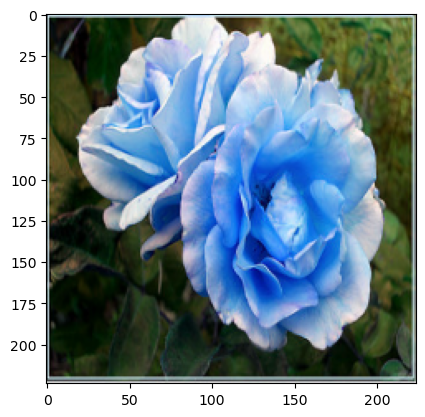

In [255]:

plt.imshow(X[2])

In [256]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


array([795, 795, 722])

In [257]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [258]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [261]:
import tf_keras

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

num_of_flowers = 5

model = tf_keras.Sequential([
  pretrained_model_without_top_layer,
    tf_keras.layers.BatchNormalization(),
    tf_keras.layers.Dropout(0.1),
    tf_keras.layers.Dense(64),
    tf_keras.layers.Dense(32),
  tf_keras.layers.Dense(num_of_flowers)
])

# Get the pre-trained model's parameters
pretrained_model_params = pretrained_model_without_top_layer.trainable_weights

    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                        

In [262]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 21s 214ms/step - loss: 0.7475 - acc: 0.7823
Epoch 2/5
86/86 [==============================] - 22s 253ms/step - loss: 0.3336 - acc: 0.8910
Epoch 3/5
86/86 [==============================] - 22s 257ms/step - loss: 0.2456 - acc: 0.9193
Epoch 4/5
86/86 [==============================] - 21s 245ms/step - loss: 0.2071 - acc: 0.9230
Epoch 5/5
86/86 [==============================] - 22s 251ms/step - loss: 0.1698 - acc: 0.9400


In [263]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 8s 248ms/step - loss: 0.4753 - acc: 0.8649


[0.4753073751926422, 0.8649237751960754]

In [264]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

In [265]:
test_image_path = 'Images/sun.jpg'
test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

1/1 [==============================] - 0s 431ms/step
Predicted class: [3]
Predicted flower: sunflowers


In [266]:
test_image_path = 'Images/daisy.jpg'
test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

1/1 [==============================] - 0s 100ms/step
Predicted class: [1]
Predicted flower: dandelion
